## Find golden pair indices in output JSON

In [1]:
def gold_idx(data, pairs):
    en_frms = set(map(lambda x: x[0], pairs))
    l2_frms = set(map(lambda x: x[1], pairs))

    en_idx = [
        i
        for i, name in enumerate(data['indices'][0])
        if data['frames'][name]['name'] in en_frms
    ]

    l2_idx = [
        i
        for i, name in enumerate(data['indices'][1])
        if data['frames'][name]['name'] in l2_frms
    ]
    
    return en_idx, l2_idx

## Prepare scoring data and gold to train classifier

In [2]:
import numpy as np
from itertools import product

def clf_data(data, gold, pairs, alignments, en_idx, l2_idx):
    for alignment in alignments:
        array = np.array(alignment['data'])
        array = array[:, l2_idx]
        alignment['np_array'] = array[en_idx].flatten()

    arrays = [a['np_array'] for a in alignments]
    
    if len(arrays) == 0:
        return np.array([]), np.array([])
    
    X = np.stack(arrays).T
    y = np.array([
        (1 if (en_frm, l2_frm) in gold else 0)
        for en_frm, l2_frm in pairs
    ])
    
    return X, y

## Read all existing alignments and preprocess data

In [3]:
import os
import re
import json

outpath = os.path.join('..', 'out')
data = []

def scores(data, features, ids=set(), exclude=False):
    if exclude:
        fn = lambda x: x['type'] not in features and x['id'] not in ids
    else:
        fn = lambda x: x['type'] in features or x['id'] in ids

    return [a for a in data['alignments'] if fn(a)]


for filename in os.listdir(outpath):
    dbname = re.search(r'\d+_(\w*)', filename).group(1)
    datapath = os.path.join(outpath, filename)
    goldpath = os.path.join('..', 'data', 'gold', f'{dbname}.txt')
    
    with open(datapath) as fp:
        outdata = json.load(fp)

    with open(goldpath) as fp:
        gold = set(map(lambda l: tuple(l.split()), fp.readlines()))
        
    pairs = []
    en_idx, l2_idx = gold_idx(outdata, gold)
    
    for f1, f2 in product(en_idx, l2_idx):
        i = outdata['indices'][0][f1]
        en_frm = outdata['frames'][i]['name']
        j = outdata['indices'][1][f2]
        l2_frm = outdata['frames'][j]['name']
        
        pairs.append((en_frm, l2_frm))

    
    # feature sets
    full = scores(outdata, ['attr_matching', 'fe_matching', 'muse_fe_matching'], exclude=True)
    fe = scores(outdata, ['attr_matching'], exclude=True)
    sym = scores(outdata, ['lu_wordnet', 'synset', 'synset_inv'], exclude=False)
    emb = scores(outdata, ['attr_matching', 'fe_matching', 'lu_wordnet', 'synset', 'synset_inv', 'muse_fe_matching'], exclude=True)
    emb_lu = scores(outdata, ['attr_matching', 'fe_matching', 'lu_wordnet', 'synset', 'synset_inv', 'muse_fe_matching'], exclude=True)

    X, y = clf_data(outdata, gold, pairs, full, en_idx, l2_idx)
    X_fe, y_fe = clf_data(outdata, gold, pairs, fe, en_idx, l2_idx)
    X_sym, y_sym = clf_data(outdata, gold, pairs, sym, en_idx, l2_idx)
    X_emb, y_emb = clf_data(outdata, gold, pairs, emb, en_idx, l2_idx)
    X_emb_lu, y_emb_lu = clf_data(outdata, gold, pairs, emb_lu, en_idx, l2_idx)
    
    data.append({
        'name': dbname,
        'X': X, 'y': y,
        'X_fe': X_fe, 'y_fe': y_fe,
        'X_sym': X_sym, 'y_sym': y_sym,
        'X_emb': X_emb, 'y_emb': y_emb,
        'X_emb_lu': X_emb_lu, 'y_emb_lu': y_emb_lu,
        'pairs': pairs,
        'features': list(map(lambda x: x['id'], full)),
        'features_fe': list(map(lambda x: x['id'], fe)),
        'features_emb': list(map(lambda x: x['id'], emb))
    })


## Variable density

In [4]:
import numpy as np 
from sklearn.neighbors import KernelDensity

lu_wordnet = data[0]['X'][:, 1]
frame_def_muse = data[0]['X'][:, 5]

lu_wordnet = lu_wordnet[lu_wordnet > 0].reshape(-1, 1)
frame_def_muse = frame_def_muse[np.random.randint(len(frame_def_muse), size=10000)].reshape(-1, 1)

In [5]:
kde_wn = KernelDensity(kernel="gaussian", bandwidth=0.01).fit(lu_wordnet)
kde_muse = KernelDensity(kernel="gaussian", bandwidth=0.01).fit(frame_def_muse.reshape(-1, 1))

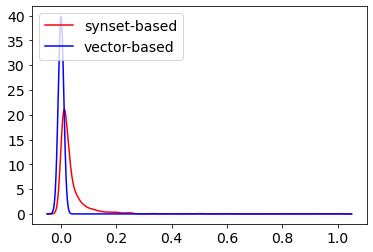

In [6]:
import matplotlib.pyplot as plt

# _, ax = plt.subplots(figsize=(10,10))

X_plot = np.linspace(-0.05, 1.05, 1000)[:, np.newaxis]
plt.plot(X_plot, np.exp(kde_wn.score_samples(X_plot)), 'r', label="synset-based")
plt.plot(X_plot, np.exp(kde_muse.score_samples(X_plot)), 'b', label="vector-based")
plt.legend(loc="upper left", fontsize=14)
plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)

plt.savefig('chart.pdf', transparent=True, dpi=300)
plt.show()
plt.close()

## Train all LogReg classifiers

In [7]:
# vars

DB_NAMES = [d['name'] for d in data]
FULL = [(d['X'], d['y']) for d in data]
FULL_FE = [(d['X_fe'], d['y_fe']) for d in data]
SYM = [(d['X_sym'], d['y_sym']) for d in data]
EMB = [(d['X_emb'], d['y_emb']) for d in data]
EMB_LU = [(d['X_emb_lu'], d['y_emb_lu']) for d in data]

In [24]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler

def train(data, dtype):
    clfs = []

    for dbname, (X, y) in zip(DB_NAMES, data):
        if len(X) == 0:
            clfs.append(None)
            continue
            
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        logreg = LogisticRegressionCV(cv=5, max_iter=300, solver='liblinear', class_weight="balanced", n_jobs=4, random_state=25)
        logreg.fit(X_scaled, y)

        clfs.append(logreg)
        print('Trained classifier for: ' + dbname + f' ({dtype})')
    
    return clfs

In [22]:
# Whole dataset classifiers
clfs = train(FULL, 'full')

Trained classifier for: swedishfn (full)
Trained classifier for: spanishfn (full)
Trained classifier for: frenchfn (full)
Trained classifier for: chinesefn (full)
Trained classifier for: japanesefn (full)
Trained classifier for: fnbrasil (full)
Trained classifier for: salsa (full)
Trained classifier for: dutchfn (full)


In [25]:
# Whole dataset + FE
fe_clfs = train(FULL_FE, 'full + FEs')

Trained classifier for: swedishfn (full + FEs)
Trained classifier for: spanishfn (full + FEs)
Trained classifier for: frenchfn (full + FEs)
Trained classifier for: chinesefn (full + FEs)
Trained classifier for: japanesefn (full + FEs)
Trained classifier for: fnbrasil (full + FEs)
Trained classifier for: salsa (full + FEs)
Trained classifier for: dutchfn (full + FEs)


In [11]:
# Symbolic methods classifiers
sym_clfs = train(SYM, 'symbolic')

Trained classifier for: swedishfn (symbolic)
Trained classifier for: spanishfn (symbolic)
Trained classifier for: frenchfn (symbolic)
Trained classifier for: chinesefn (symbolic)
Trained classifier for: japanesefn (symbolic)
Trained classifier for: fnbrasil (symbolic)
Trained classifier for: salsa (symbolic)
Trained classifier for: dutchfn (symbolic)


In [12]:
# Distributional methods classifiers
emb_clfs = train(EMB, 'distributional')

Trained classifier for: swedishfn (distributional)
Trained classifier for: spanishfn (distributional)
Trained classifier for: frenchfn (distributional)
Trained classifier for: japanesefn (distributional)
Trained classifier for: fnbrasil (distributional)
Trained classifier for: salsa (distributional)
Trained classifier for: dutchfn (distributional)


In [13]:
# Distributional methods (for LUs only) classifiers
emb_lu_clfs = train(EMB_LU, 'distributional LU only')

Trained classifier for: swedishfn (distributional LU only)
Trained classifier for: spanishfn (distributional LU only)
Trained classifier for: frenchfn (distributional LU only)
Trained classifier for: japanesefn (distributional LU only)
Trained classifier for: fnbrasil (distributional LU only)
Trained classifier for: salsa (distributional LU only)
Trained classifier for: dutchfn (distributional LU only)


In [30]:
import matplotlib 
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score, PrecisionRecallDisplay, precision_recall_curve
from sklearn.preprocessing import StandardScaler

matplotlib.rcParams.update({'font.size': 18})

plot_name = {
    'chinesefn': 'Chinese FN',
    'dutchfn': 'Dutch FN',
    'fnbrasil': 'FN Brasil',
    'frenchfn': 'French FN',
    'japanesefn': 'Japanese FN',
    'salsa': 'Salsa',
    'spanishfn': 'Spanish FN',
    'swedishfn': 'Swedish FN',
}

def plot(data, clfs, filename = None):
    _, ax = plt.subplots(figsize=(10, 10))
    plot_data = []

    for name, (X, y), clf in zip(DB_NAMES, data, clfs):
        if clf is None:
            continue
            
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        y_pred = clf.decision_function(X_scaled)
        precision, recall, _ = precision_recall_curve(y, y_pred)
    
        numerator = 2 * recall * precision
        denom = recall + precision
        f1_scores = np.divide(numerator, denom, out=np.zeros_like(denom), where=(denom!=0))
        max_f1 = np.max(f1_scores)
        
        plot_data.append((precision, recall, max_f1, name))

    plot_data.sort(key=lambda x: -x[2])
    
    for p, r, f, n in plot_data:
        display = PrecisionRecallDisplay(p, r)
        display.plot(ax=ax, name=f'{plot_name[n]} (F1 = {f:.2f})')
    
    handles, labels = display.ax_.get_legend_handles_labels()
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_title("Precision-Recall Curves for All FrameNet Databases")
    lgd = ax.legend(handles=handles, labels=labels, loc="center left", bbox_to_anchor=(1,0.5))

    if filename is not None:
        plt.savefig(filename, transparent=True, dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')
    
    plt.show()
    plt.close()

In [31]:
# Plot full
# plot(FULL, clfs, 'full-scores.pdf')

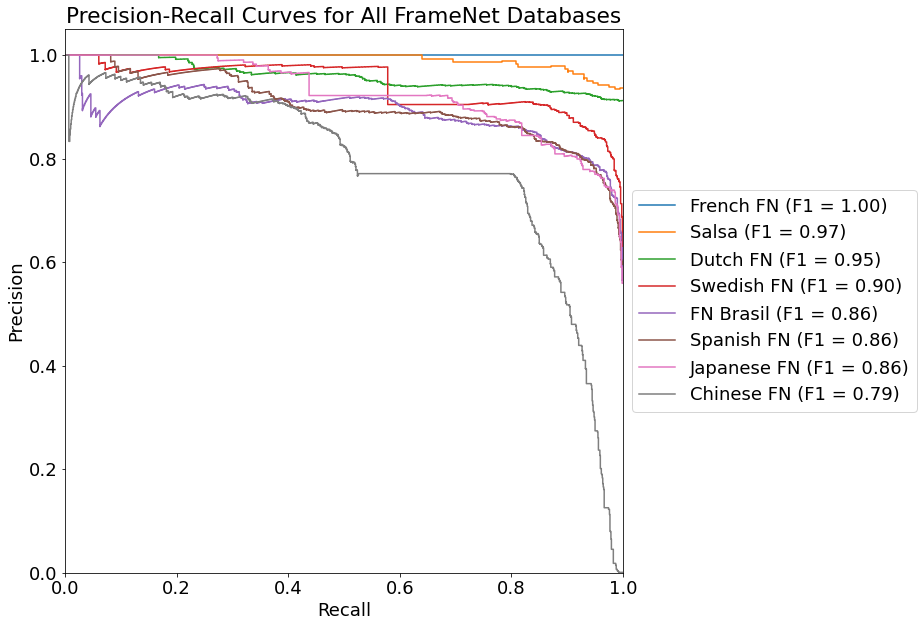

In [32]:
# Plot full FE
plot(FULL_FE, fe_clfs, 'full-fe-scores.pdf')

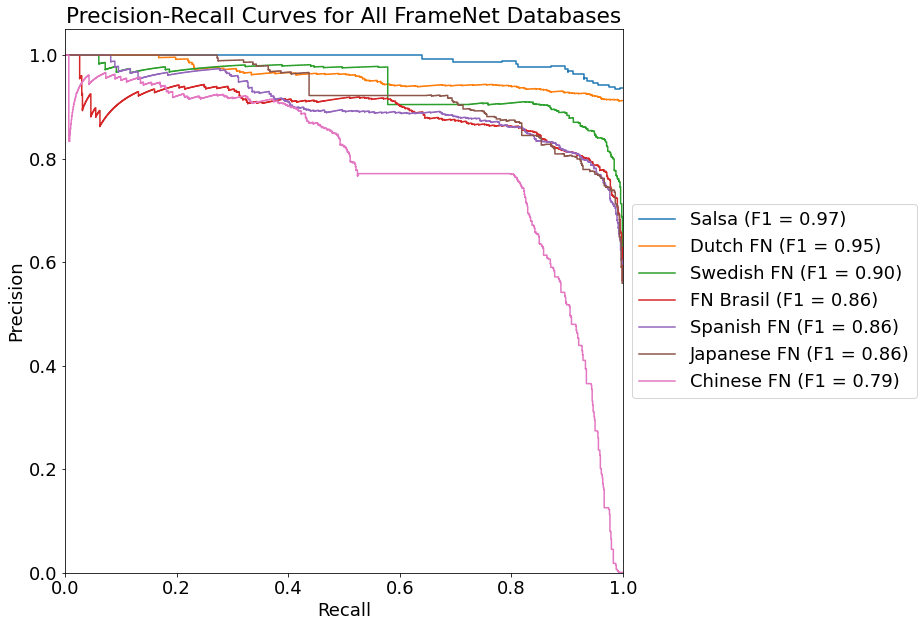

In [33]:
# Plot full FE (no french)
french_idx = next(i for i, d in enumerate(data) if d['name'] == 'frenchfn')
fe_clfs_ = fe_clfs[:french_idx] + fe_clfs[french_idx+1:]
FULL_FE_ = FULL_FE[:french_idx] + FULL_FE[french_idx+1:]

DB_NAMES = [d['name'] for d in data if d['name'] != 'frenchfn']
plot(FULL_FE_, fe_clfs_, 'full-fe-scores(no frenchfn).pdf')
DB_NAMES = [d['name'] for d in data]

In [ ]:
# Plot symbolic
# plot(SYM, sym_clfs, 'symbolic-scores.pdf')

In [ ]:
# Plot distributional
# plot(EMB, emb_clfs, 'distributional-scores.pdf')

In [ ]:
# Plot distributional LU only
# plot(EMB_LU, emb_lu_clfs, 'distributional-scores-lu.pdf')

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

for d, clf, sym_clf, emb_clf, emb_lu_clf in zip(data, clfs, sym_clfs, emb_clfs, emb_lu_clfs):    
    X = StandardScaler().fit_transform(d['X'])
    X_sym = StandardScaler().fit_transform(d['X_sym'])
    
    name = d['name']
    pairs = np.empty(len(d['pairs']), dtype=object)
    pairs[:] = d['pairs']
    
    df_data = {
        'full': pairs[clf.decision_function(X).argsort()[::-1]][:100],
        'symbolic': pairs[sym_clf.decision_function(X_sym).argsort()[::-1]][:100],
    }
    
    if len(d['X_emb']) > 0:
        X_emb = StandardScaler().fit_transform(d['X_emb'])
        df_data['distributional'] = pairs[emb_clf.decision_function(X_emb).argsort()[::-1]][:100]
    else:
        df_data['distributional'] = np.zeros((100,), dtype=object)
        
    if len(d['X_emb_lu']) > 0:
        X_emb_lu = StandardScaler().fit_transform(d['X_emb_lu'])
        df_data['distributional_lu'] = pairs[emb_lu_clf.decision_function(X_emb_lu).argsort()[::-1]][:100]
    else:
        df_data['distributional_lu'] = np.zeros((100,), dtype=object)
        
    pd.DataFrame(df_data).to_csv(f'{name}-top-100.csv')

## Feature coefficients (full)

In [ ]:
index = []
feat_data = []

for d, clf in zip(data, clfs):
    feats = np.array(d['features'])
    idx = (-clf.coef_).argsort()
    
    index.append(d['name'])
    feat_data.append({
        f: "%.2f" % c
        for f, c in zip(feats[idx][0], clf.coef_[0][idx][0])
    })

df = pd.DataFrame(feat_data, index=index)
df.to_csv(f'feature-coefficients-full.csv')
df

## Feature coefficients (Full + FEs)

In [ ]:
index = []
feat_data = []

for d, clf in zip(data, fe_clfs):
    feats = np.array(d['features_fe'])
    idx = (-clf.coef_).argsort()

    index.append(d['name'])
    feat_data.append({
        f: "%.2f" % c
        for f, c in zip(feats[idx][0], clf.coef_[0][idx][0])
    })

df = pd.DataFrame(feat_data, index=index)
df.to_csv(f'feature-coefficients-full-fe.csv')
df

## Swedish and Japanese "elbow" analysis

In [ ]:
d, clf = next((d, clf) for d, clf in zip(data, fe_clfs) if d['name'] == 'japanesefn')
    
scaler = StandardScaler()
X_scaled = scaler.fit_transform(d['X_fe'])
y = d['y_fe']
y_pred = clf.decision_function(X_scaled)
precision, recall, thres = precision_recall_curve(y, y_pred)

np.diff(-precision).argsort()[:10]

In [ ]:
thres.min()

In [ ]:
precision[294:300]

In [ ]:
recall[294:300]

In [ ]:
thres[294:300]

In [ ]:
y[y_pred > 6.15303508].shape

In [ ]:
y[y_pred > 6.26042263].shape

In [ ]:
np.array(d['pairs'])[(y == 1) & (y_pred > 6.15303508) & (y_pred < 6.26042263)]

In [ ]:
d = next(d for d in data if d['name'] == 'dutchfn')

In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split

X, y = d['X'], d['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)

In [ ]:
from imblearn.under_sampling import RandomUnderSampler 

rus = RandomUnderSampler(random_state=1)
X_res, y_res = rus.fit_resample(X_train, y_train)

In [ ]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

svm = make_pipeline(StandardScaler(), SVC(gamma='auto', class_weight='balanced'))
svm.fit(X_train, y_train)

In [ ]:
svm.score(X_test, y_test)

In [ ]:
from sklearn.metrics import average_precision_score

y_pred = svm.decision_function(X_test)
average_precision = average_precision_score(y_test, y_pred)

average_precision

In [ ]:
from sklearn.metrics import f1_score

f1_score(y_test, svm.predict(X_test))